# Cross Validation

> More info can be found [here](https://www.turing.com/kb/different-types-of-cross-validations-in-machine-learning-and-their-explanations).
## Types

1. Hold-out Cross Validation: AKA train test split. To get started, the data sample is divided into two parts - Training Data Set and Testing Data Set. <br><br>
2. K-Fold Cross Validation: The parameter for this type is 'K' which refers to the number of subsets or folds obtained from the data sample. The first step is to train the model using the entire data set. The second step is to divide the data sample in 'k' number of subsets (let us suppose, 11). From hereon, these subsets become the testing data sets that are then used for testing the validation of a model one by one. 
This particular type of cross-validation is considered to be an unbiased and inclusive validation method as it involves the training and testing of almost every subset. <br><br>
3. Repeated K-Fold Cross Validation: Repeated k-fold cross-validation provides a way to improve the estimated performance of a machine learning model. This involves simply repeating the cross-validation procedure multiple (N) times and reporting the mean result across all folds from all runs. <br><br>
4. Stratified K-Fold Cross Validation: It involves the division of data sample sets into 'k' subsets or folds and it's only applicable to `classification` problems. In order to ensure that there is no biased division of data in 'k' folds, the process of stratification is conducted to rearrange the data in such a manner that each fold represents the whole data. i.e it's used for `imbalanced data`. <br><br>
5. Leave P Out Cross Validation: Another type of cross-validation is the Leave-p-out cross-validation method. Herein, the data sample comprises data points (n). The total number of data points (n) is used to separate a set of data points that is used for testing. These data points are referred to as (p). The training data set is obtained by calculating (n-p) and the model is trained accordingly. Once the training is done, p data points are used for cross-validation.  <br><br>
6. Leave One Out Cross Validation: A variant of the Leave-p-out cross-validation method, the Leave-one-out cross-validation is another type of cross-validation. Herein, p is kept to be 1 (p=1) and the n-p data points are used to train the model. Thus, when the training is done, the p data point or a single data point is used to validate the model. One of the biggest drawbacks of this type is that a major part of the data sample is used for training the model, however, only a single data point is used to evaluate its accuracy.  Therefore, this type is often considered to be an expensive method. 

In [1]:
from typing import Optional
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Custom import
from src.data_manager import load_data, split_data
from src.metrics import plot_confusion_matrix, hyperparam_space

# pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600
%load_ext lab_black

%load_ext autoreload
%autoreload 2

### Evaluating The Model Using Cross Validation

* Cross validation can be used to:
  * Evaluate model performance.
  * Select the best model hyperparameters.


In [2]:
# Load data
fp = "../../data/titanic_train.csv"
data = load_data(filename=fp)
data.head()

Shape of data: (891, 12)

Duration: 0.008 seconds


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
from feature_engine.encoding import RareLabelEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.selection import DropFeatures
from feature_engine.imputation import (
    MeanMedianImputer,
    CategoricalImputer,
    AddMissingIndicator,
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [4]:
# Drop `Cabin` it has to many missing values and unique values
vars_to_drop = ["PassengerId", "Name", "Cabin", "Ticket"]
vars_wf_na_median = ["Age"]
vars_wf_na_most_freq = ["Embarked"]
vars_to_ohe = ["Pclass", "Sex", "Embarked", "Parch", "SibSp"]
vars_wf_rare_labels = ["Parch", "SibSp"]
RARE_LABEL_THRESH = 0.05
vars_to_transform = ["Age", "Fare"]
target = "Survived"

RANDOM_STATE = 123
N_ESTIMATORS = 20
MAX_ITER = 10_000

In [5]:
processor_pipe = Pipeline(
    steps=[
        # === Drop variables ===
        ("drop_vars", DropFeatures(features_to_drop=vars_to_drop)),
        # === Replace NaNs with median ===
        (
            "vars_wf_na_median",
            MeanMedianImputer(imputation_method="median", variables=vars_wf_na_median),
        ),
        # === Replace NaNs with most frequent ===
        ("vars_wf_na_most_freq", CategoricalImputer(imputation_method="frequent")),
        # === Add flags for variables with NaNs ===
        (
            "nan_flag",
            AddMissingIndicator(variables=vars_wf_na_median + vars_wf_na_most_freq),
        ),
        # === Remove rare labels ===
        (
            "vars_wf_rare_labels",
            RareLabelEncoder(
                tol=RARE_LABEL_THRESH,
                n_categories=5,
                variables=vars_wf_rare_labels,
                ignore_format=True,
            ),
        ),
        # === Column Transformer ===
        (
            "ohe",
            SklearnTransformerWrapper(
                transformer=OneHotEncoder(
                    dtype=int, handle_unknown="ignore", sparse=False
                ),
                variables=vars_to_ohe,
            ),
        ),
        (
            "normalizer",
            SklearnTransformerWrapper(
                transformer=MinMaxScaler(), variables=vars_to_transform
            ),
        ),
    ]
)

processor_pipe

Pipeline(steps=[('drop_vars',
                 DropFeatures(features_to_drop=['PassengerId', 'Name', 'Cabin',
                                                'Ticket'])),
                ('vars_wf_na_median', MeanMedianImputer(variables=['Age'])),
                ('vars_wf_na_most_freq',
                 CategoricalImputer(imputation_method='frequent')),
                ('nan_flag',
                 AddMissingIndicator(variables=['Age', 'Embarked'])),
                ('vars_wf_rare_labels',
                 RareLabelEncoder(ignore_format=True, n_categories=5,
                                  variables=['Parch', 'SibSp'])),
                ('ohe',
                 SklearnTransformerWrapper(transformer=OneHotEncoder(dtype=<class 'int'>,
                                                                     handle_unknown='ignore',
                                                                     sparse=False),
                                           variables=['Pclass', 'Sex',
                                                      'Embarked', 'Parch',
                                                      'SibSp'])),
                ('normalizer',
                 SklearnTransformerWrapper(transformer=MinMaxScaler(),
                                           variables=['Age', 'Fare']))])

In [6]:
df = processor_pipe.fit_transform(data)

# Split data
X_train, X_validation, y_train, y_validation = split_data(
    data=df, target="Survived", display_shapes=True
)

X_train.shape, X_validation.shape

Shape of X_train: (712, 17), 
Shape of X_validation: (179, 17)
Duration: 0.003 seconds


((712, 17), (179, 17))

In [7]:
X_train.head(3)

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Parch_0,Parch_1,Parch_2,Parch_Rare,SibSp_0,SibSp_1,SibSp_Rare
329,0.195778,0.113168,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0
749,0.384267,0.015127,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0
203,0.566474,0.014102,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0


In [8]:
y_train.value_counts(normalize=True)

0    0.610955
1    0.389045
Name: Survived, dtype: float64

### K-Fold Cross-Validation

In [9]:
from sklearn.model_selection import (
    KFold,
    RepeatedKFold,
    LeaveOneOut,
    StratifiedKFold,
    cross_validate,
)

In [10]:
# Logistic Regression
log_model = LogisticRegression(
    penalty="l2", C=10, solver="liblinear", random_state=RANDOM_STATE, max_iter=MAX_ITER
)

# K-Fold Cross-Validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Estimate generalization error
clf = cross_validate(
    estimator=log_model,
    X=X_train,
    y=y_train,
    scoring="accuracy",
    return_train_score=True,
    cv=k_fold,
)

In [11]:
clf

{'fit_time': array([0.00475788, 0.00409603, 0.00367308, 0.00414395, 0.00378394]),
 'score_time': array([0.00229287, 0.0020051 , 0.00199699, 0.00195813, 0.00194097]),
 'test_score': array([0.83916084, 0.8041958 , 0.81690141, 0.78873239, 0.76760563]),
 'train_score': array([0.79086116, 0.80492091, 0.80175439, 0.8122807 , 0.8122807 ])}

In [12]:
clf.get("test_score")

array([0.83916084, 0.8041958 , 0.81690141, 0.78873239, 0.76760563])

In [13]:
print(
    f'mean train set accuracy: {np.mean(clf.get("train_score"))} +- {np.std(clf.get("train_score"))}\n'
)

print(
    f'mean train set accuracy: {np.mean(clf.get("test_score"))} +- {np.std(clf.get("test_score"))}\n'
)

mean train set accuracy: 0.8044195726574784 +- 0.007934479443352188

mean train set accuracy: 0.8033192159952722 +- 0.02432324660964456



### Repeated K-Fold Cross-Validation

In [14]:
# Logistic Regression
log_model = LogisticRegression(
    penalty="l2", C=10, solver="liblinear", random_state=RANDOM_STATE, max_iter=MAX_ITER
)

# Repeated K-Fold Cross-Validation
r_k_fold = RepeatedKFold(
    n_splits=5,
    n_repeats=10,
    random_state=RANDOM_STATE,
)

# Estimate generalization error
clf = cross_validate(
    estimator=log_model,
    X=X_train,
    y=y_train,
    scoring="accuracy",
    return_train_score=True,
    cv=r_k_fold,
)

In [15]:
print(
    f'mean train set accuracy: {np.mean(clf.get("train_score"))} +- {np.std(clf.get("train_score"))}\n'
)

print(
    f'mean train set accuracy: {np.mean(clf.get("test_score"))} +- {np.std(clf.get("test_score"))}\n'
)

mean train set accuracy: 0.8071610396818055 +- 0.008061144488868391

mean train set accuracy: 0.7960415640697331 +- 0.02833111303920891



### Leave One Out Cross-Validation

* This is computationally expensive if you have too many data points.

In [16]:
# Logistic Regression
log_model = LogisticRegression(
    penalty="l2", C=10, solver="liblinear", random_state=RANDOM_STATE, max_iter=MAX_ITER
)

# Leave One Out Cross-Validation
l_one_out = LeaveOneOut()

# Estimate generalization error
clf = cross_validate(
    estimator=log_model,
    X=X_train,
    y=y_train,
    scoring="accuracy",
    return_train_score=True,
    cv=l_one_out,
)

print(f'Number of metrics obtained: { len(clf.get("test_score"))}')

Number of metrics obtained: 712


In [17]:
print(
    f'mean train set accuracy: {np.mean(clf.get("train_score"))} +- {np.std(clf.get("train_score"))}\n'
)

print(
    f'mean train set accuracy: {np.mean(clf.get("test_score"))} +- {np.std(clf.get("test_score"))}\n'
)

mean train set accuracy: 0.8060434741383398 +- 0.000527921621945519

mean train set accuracy: 0.800561797752809 +- 0.3995780345959967



### Stratified Cross-Validation

In [18]:
# Logistic Regression
log_model = LogisticRegression(
    penalty="l2", C=10, solver="liblinear", random_state=RANDOM_STATE, max_iter=MAX_ITER
)

# Stratified Cross-Validation
s_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Estimate generalization error
clf = cross_validate(
    estimator=log_model,
    X=X_train,
    y=y_train,
    scoring="accuracy",
    return_train_score=True,
    cv=s_k_fold,
)

print(f'Number of metrics obtained: { len(clf.get("test_score"))}')

Number of metrics obtained: 5


In [19]:
print(
    f'mean train set accuracy: {np.mean(clf.get("train_score"))} +- {np.std(clf.get("train_score"))}\n'
)

print(
    f'mean train set accuracy: {np.mean(clf.get("test_score"))} +- {np.std(clf.get("test_score"))}\n'
)

mean train set accuracy: 0.8016113218018684 +- 0.009031367214529755

mean train set accuracy: 0.7976854131783708 +- 0.030374536764273326



<hr><br>

## Cross-Validation With Grid Search
* Cross validation to optimize hyperparameters.

In [20]:
from sklearn.model_selection import GridSearchCV

### K-Fold

In [21]:
# Logistic Regression
log_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=MAX_ITER)

# hyperparameter space
param_grid = dict(
    penalty=["l1", "l2"],
    C=[0.01, 0.1, 1, 10],
)

# K-Fold Cross-Validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Search
clf = GridSearchCV(
    log_model,
    param_grid,
    scoring="accuracy",
    cv=k_fold,
    refit=True,  # refits best model to entire dataset
)

search_grid = clf.fit(X_train, y_train)

# Best hyperparameters
search_grid.best_params_

{'C': 10, 'penalty': 'l2'}

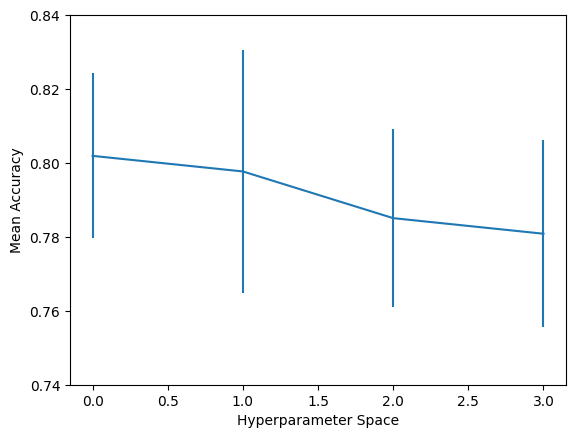

,params,mean_test_score,std_test_score
0,"{'C': 10, 'penalty': 'l2'}",0.801921,0.022343
1,"{'C': 1, 'penalty': 'l2'}",0.797705,0.032803
2,"{'C': 0.1, 'penalty': 'l2'}",0.785068,0.024162
3,"{'C': 0.01, 'penalty': 'l2'}",0.780853,0.025314
4,"{'C': 0.01, 'penalty': 'l1'}",NaN,NaN
5,"{'C': 0.1, 'penalty': 'l1'}",NaN,NaN
6,"{'C': 1, 'penalty': 'l1'}",NaN,NaN
7,"{'C': 10, 'penalty': 'l1'}",NaN,NaN


In [22]:
results = hyperparam_space(
    search_grid=search_grid, ylabel="Mean Accuracy", ylim=(0.74, 0.84)
)

results

<hr>

### Repeated K-Fold

In [23]:
# Logistic Regression
log_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=MAX_ITER)

# hyperparameter space
param_grid = dict(
    penalty=["l1", "l2"],
    C=[0.01, 0.1, 1, 10],
)

# Repeated K-Fold Cross-Validation
r_k_fold = RepeatedKFold(
    n_splits=5,
    n_repeats=10,
    random_state=RANDOM_STATE,
)

# Search
clf = GridSearchCV(
    log_model,
    param_grid,
    scoring="accuracy",
    cv=r_k_fold,
    refit=True,  # refits best model to entire dataset
)

search_grid = clf.fit(X_train, y_train)

# Best hyperparameters
search_grid.best_params_

{'C': 10, 'penalty': 'l2'}

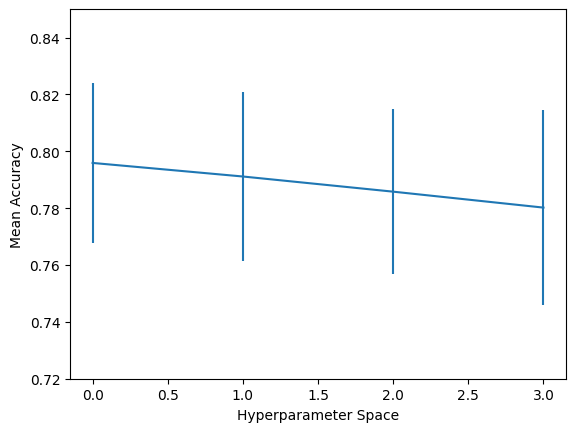

,params,mean_test_score,std_test_score
0,"{'C': 10, 'penalty': 'l2'}",0.795902,0.028240
1,"{'C': 1, 'penalty': 'l2'}",0.791127,0.029728
2,"{'C': 0.1, 'penalty': 'l2'}",0.785793,0.029134
3,"{'C': 0.01, 'penalty': 'l2'}",0.780187,0.034352
4,"{'C': 0.01, 'penalty': 'l1'}",NaN,NaN
5,"{'C': 0.1, 'penalty': 'l1'}",NaN,NaN
6,"{'C': 1, 'penalty': 'l1'}",NaN,NaN
7,"{'C': 10, 'penalty': 'l1'}",NaN,NaN


In [24]:
results = hyperparam_space(
    search_grid=search_grid, ylabel="Mean Accuracy", ylim=(0.72, 0.85)
)

results

<hr>

### Stratified K-Fold

* Since the class labels are imbalanced, I'll build an ML model with this method.

In [25]:
# Logistic Regression
log_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=MAX_ITER)

# hyperparameter space
param_grid = dict(
    penalty=["l1", "l2"],
    C=[0.01, 0.1, 1, 10],
)

# Stratified Cross-Validation
s_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Search
clf = GridSearchCV(
    log_model,
    param_grid,
    scoring="accuracy",
    cv=s_k_fold,
    refit=True,  # refits best model to entire dataset
)

clf_grid = clf.fit(X_train, y_train)

# Best hyperparameters
clf_grid.best_params_

{'C': 10, 'penalty': 'l2'}

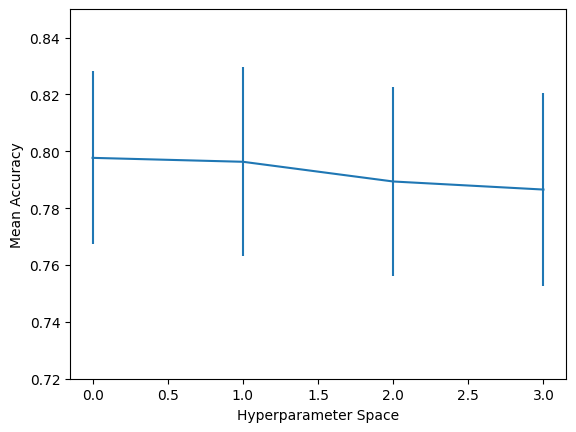

,params,mean_test_score,std_test_score
0,"{'C': 10, 'penalty': 'l2'}",0.797685,0.030375
1,"{'C': 1, 'penalty': 'l2'}",0.796307,0.033247
2,"{'C': 0.1, 'penalty': 'l2'}",0.789373,0.033298
3,"{'C': 0.01, 'penalty': 'l2'}",0.786536,0.033961
4,"{'C': 0.01, 'penalty': 'l1'}",NaN,NaN
5,"{'C': 0.1, 'penalty': 'l1'}",NaN,NaN
6,"{'C': 1, 'penalty': 'l1'}",NaN,NaN
7,"{'C': 10, 'penalty': 'l1'}",NaN,NaN


In [26]:
results = hyperparam_space(
    search_grid=clf_grid, ylabel="Mean Accuracy", ylim=(0.72, 0.85)
)

results

In [27]:
# Make predictions
train_pred = clf_grid.predict(X_train)
validation_pred = clf_grid.predict(X_validation)

expected_score, std = 0.797685, 0.030375
print(
    f"Expected Accuracy Range: \nLower: {expected_score - std} \nUpper: {expected_score + std}\n"
)
print(f"Train Mean accuracy: {accuracy_score(y_true=y_train, y_pred=train_pred)}\n")
print(
    f"Validation Mean accuracy: {accuracy_score(y_true=y_validation, y_pred=validation_pred)}"
)

Expected Accuracy Range: 
Lower: 0.7673099999999999 
Upper: 0.82806

Train Mean accuracy: 0.8061797752808989

Validation Mean accuracy: 0.8212290502793296


<hr>

### Leave One Out Cross Validation

In [28]:
# Logistic Regression
log_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=MAX_ITER)

# hyperparameter space
param_grid = dict(
    penalty=["l1", "l2"],
    C=[0.01, 0.1, 1, 10],
)

# Leave One Out Cross-Validation
l_one_out = LeaveOneOut()

# Search
clf = GridSearchCV(
    log_model,
    param_grid,
    scoring="accuracy",
    cv=l_one_out,
    refit=True,  # refits best model to entire dataset
)

search_grid = clf.fit(X_train, y_train)

# Best hyperparameters
search_grid.best_params_

{'C': 10, 'penalty': 'l2'}

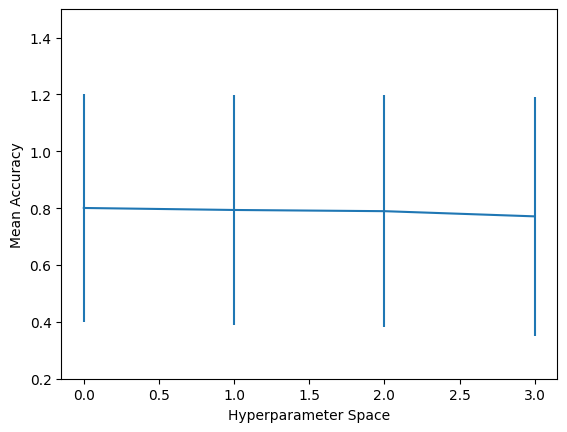

,params,mean_test_score,std_test_score
0,"{'C': 10, 'penalty': 'l2'}",0.800562,0.399578
1,"{'C': 1, 'penalty': 'l2'}",0.793539,0.404765
2,"{'C': 0.1, 'penalty': 'l2'}",0.789326,0.407787
3,"{'C': 0.01, 'penalty': 'l2'}",0.771067,0.420146
4,"{'C': 0.01, 'penalty': 'l1'}",NaN,NaN
5,"{'C': 0.1, 'penalty': 'l1'}",NaN,NaN
6,"{'C': 1, 'penalty': 'l1'}",NaN,NaN
7,"{'C': 10, 'penalty': 'l1'}",NaN,NaN


In [29]:
results = hyperparam_space(
    search_grid=search_grid, ylabel="Mean Accuracy", ylim=(0.20, 1.5)
)

results

#### Comment

* The standard devaiation is very high. This is because we're testing on a single value.

## Nested Cross Validation

* This approach with an example can be found [here](https://github.com/chineidu/hyperparameter-optimization/blob/master/Section-04-Cross-Validation/04-04-Nested-Cross-Validation.ipynb).